SETUP

Total class: 10
            <br>'Background': 0,
            <br>'Water': 1,
            <br>'Building_No_Damage': 2,
            <br>'Building_Minor_Damage': 3,
            <br>'Building_Major_Damage': 4, <br>'Building_Total_Destruction': 5
            <br>'Vehicle': 6,
            <br>'Road-Clear': 7,
            <br>'Road-Blocked': 8,
            <br>'Tree': 9,
            <br>'Pool': 10.
           
Total image: 4494 (Train: 3595, Val: 449, Test: 450)

#### Install and Import library

In [1]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 2.0 MB/s eta 0:00:00


In [2]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.4 MB/s eta 0:00:00


In [3]:
#pip install torchinfo
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 14.5 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount("/content/drive")
import torch
#import torchinfo
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torchvision import transforms as transform
from PIL import Image
import numpy as np
import os
import cv2 as cv
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
from torchvision.transforms import InterpolationMode as Inter
from torchmetrics.classification import MulticlassJaccardIndex
import time
import random
import torch.nn.functional as F
import pandas as pd

Mounted at /content/drive


#### Setup labels and Class Colors

In [5]:
# set up dataset addresses
data_path = 'drive/MyDrive/comp-vision-project/data/RescueNet.zip_(Unzipped Files)/'
train_org_path = data_path + 'train/train-org-img/'
train_label_path = data_path + 'train/train-label-img/'

val_org_path = data_path + 'val/val-org-img/'
val_label_path = data_path + 'val/val-label-img/'

test_org_path = data_path + 'test/test-org-img/'
test_label_path = data_path + 'test/test-label-img/'

model_path = data_path + 'model_weights/'

device = "cuda" if torch.cuda.is_available() else "cpu"

label_dict = {
    0: 'Background',
    1: 'Water',
    2: 'Building_No_Damage',
    3: 'Building_Minor_Damage',
    4: 'Building_Major_Damage',
    5: 'Building_Total_Destruction',
    6: 'Vehicle',
    7: 'Road-Clear',
    8: 'Road-Blocked',
    9: 'Tree',
    10: 'Pool'
    }
color_dict = {
    0: (0, 0, 0),  # Black for Background
    1: (0, 0, 255),  # Blue for Water
    2: (0, 255, 0),  # Green for Building_No_Damage
    3: (255, 154, 0),  # Orange for Building_Minor_Damage
    4: (0, 128, 255),  # Dark Orange for Building_Major_Damage
    5: (185, 120, 22),  # Dark Blue for Building_Total_Destruction
    6: (255, 0, 0),  # Red for Vehicle
    7: (128, 128, 128),  # Gray for Road-Clear
    8: (255, 255, 0),  # Yellow for Road-Blocked
    9: (0, 255, 255),  # Cyan for Tree
    10: (255, 0, 255)  # Magenta for Pool
    }

legend_elements = []
for label, color in color_dict.items():
  legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label_dict[label], markerfacecolor=tuple(np.array(color)/255), markersize=10))

#### Help Functions

In [6]:
def display_predict_label(p_array, a_array, filename, set_type='train', ID=''):
  """Displays a 2D numpy array as an image using the provided color_dict."""
  # PURPOSE: given two arrays display the colorMaps of each images next to each other
  # Create an RGB image from the array
  print(filename)
  p_image = np.zeros((p_array.shape[0], p_array.shape[1], 3), dtype=np.uint8)
  for label, color in color_dict.items():
    p_image[p_array == label] = color

  a_image = np.zeros((a_array.shape[0], a_array.shape[1], 3), dtype=np.uint8)
  for label, color in color_dict.items():
    a_image[a_array == label] = color

  if set_type == 'train':
    path = train_org_path
  elif set_type == 'val':
    path = val_org_path
  elif set_type == 'test':
    path = test_org_path

  org_image = cv.imread(path+filename)
  org_image = cv.cvtColor(org_image, cv.COLOR_BGR2RGB)
  fig, axes = plt.subplots(1, 3, figsize=(10, 5))
  # Display the image
  axes[0].imshow(org_image)
  axes[0].set_title('Original')
  #axes[0].axis('off')

  axes[1].imshow(p_image)
  axes[1].set_title(ID+' Pred.')
  #axes[1].axis('off')

  axes[2].imshow(a_image)
  axes[2].set_title('Label')
  #axes[2].axis('off')

  plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.tight_layout()
  plt.show()

def display_classmap(array, get_image=False):
  """Displays a 2D numpy array as an image using the provided color_dict."""

  # Create an RGB image from the array
  image = np.zeros((array.shape[0], array.shape[1], 3), dtype=np.uint8)
  for label, color in color_dict.items():
    if array.ndim == 2:
      image[array == label] = color
    else:
      for channel in range(array.shape[2]):
        image[array[:,:,channel] == label, channel] = color[channel]
  if get_image:
    return image
  else:
    # Display the image
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.imshow(image)
    plt.title('Prediction Map')
    plt.show()

def display_org_label(org_path, label_path, idx):
  org_list, label_list = os.listdir(org_path), os.listdir(label_path)
  org_list.sort(), label_list.sort()

  org_img = cv.imread(org_path+org_list[idx])
  label_img = cv.imread(label_path+label_list[idx])
  label_img = cv.cvtColor(label_img, cv.COLOR_BGR2RGB)
  org_img = cv.cvtColor(org_img, cv.COLOR_BGR2RGB)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(org_img)
  axes[0].set_title('Original Image')

  label_img = display_classmap(label_img, get_image=True)
  axes[1].imshow(label_img)
  axes[1].set_title('Label Image')

  plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

  plt.tight_layout()
  plt.show()
  #return org_img, label_img

def SingleImage_evaluate(models, dataloader, set_type):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  iou_metric = MulticlassJaccardIndex(num_classes=11).to(device = "cuda" if torch.cuda.is_available() else "cpu")
  file_name, input_batch, target_batch = next(iter(dataloader))
  for id, model in models.items():
    model.eval()
    total_loss = 0.0
    start = time.time()
    with torch.no_grad():
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        target_batch = target_batch.squeeze(1)  # Remove the channel dimension (assuming it's 1)
        main_output, _ = model(input_batch)
        output_predictions = main_output[0].argmax(0)
        iou_metric.update(main_output, target_batch)
        iou = iou_metric.compute()
        print(f"{id} iou: {iou}")
        print('eval time', time.time()-start)
        display_predict_label(output_predictions.cpu().numpy(), target_batch[0].numpy(), file_name[0], set_type=set_type, ID=id)
  return output_predictions, target_batch, file_name

In [7]:
images_2_keep = SingleImage_evaluate({'model_1': DL3_model_1}, val_loader, 'val', )

NameError: name 'DL3_model_1' is not defined

In [ ]:
np.save(data_path+'predictions/' + images_2_keep[2][0] +'_predict.npy', images_2_keep[0])
np.save(data_path+'predictions/' + images_2_keep[2][0] +'_label.npy', images_2_keep[1][0,:,:])

In [ ]:
os.listdir(data_path+'predictions/')

#### Example Image

In [ ]:
# Dataset notes
# 3595 in training set code: len(os.listdir(data_path+train_org_path))
# orginal image shape size (3000, 4000, 3)

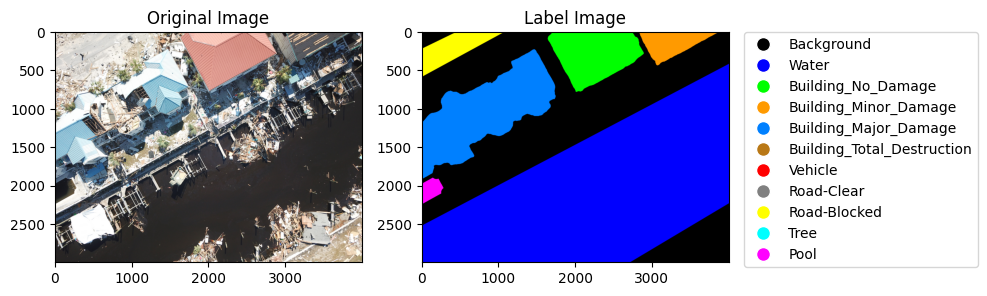

In [8]:
display_org_label(train_org_path, train_label_path, 1)

### Preprocessing & Dataset

In [11]:
# dataset class object
class RescueNetDataset(torch.utils.data.Dataset):
  def __init__(self, org_path, label_path, size=(800,500)): #
    self.org_path = org_path # set orginal image path
    self.label_path = label_path # set label image path
    self.size = size # set image resize

    # preprocess original image, turn into tensor, normailize according to deeplabV3 documentation
    self.org_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # get filenames for image. store for use in getitem func
    self.org_files = os.listdir(self.org_path)
    self.org_files.sort()

    self.label_files = os.listdir(self.label_path)
    self.label_files.sort()

  # get size of dataset
  def __len__(self):
    return len(self.org_files)

  # get image based on index of sorted filenames
  def __getitem__(self,idx):
    # read in original image, update color format, 0 to 1 scaling, resize for ease of computation
    org = cv.imread(self.org_path+self.org_files[idx])
    if org.size != (3000, 4000, 3):
      org = org[:3000, :4000,:]
    org = cv.cvtColor(org, cv.COLOR_BGR2RGB)
    org = org.astype(np.float32) / 255.0

    # read in label image, update color format, resize with nearest neighbor interpolation to preserve integer values [minibatch, channel, height, width]
    label = cv.imread(self.label_path+self.label_files[idx])
    label = cv.cvtColor(label, cv.COLOR_BGR2RGB)
    if label.size != (3000, 4000, 3):
      label = label[:3000, :4000,:] # if image is not expect size, crop image
    if label.dtype != np.uint8: # check if label is still an integer
      print('label dytpye not np.uint8')
      print('label dtype:', label.dtype)
    # transform numpy arrays to tensors
    org = self.org_transform(org)
    label = torch.from_numpy(label)
    channel = 1
    label = label[:,:,channel].unsqueeze(dim=0)

    return self.org_files[idx], org, label

### Create Model

In [12]:
class CustomDeepLabV3(torch.nn.Module):
    def __init__(self, num_classes=11, input_size=(500, 800), output_size=(3000,4000)):
        super(CustomDeepLabV3, self).__init__()
        self.base_model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        self.base_model.classifier = DeepLabHead(2048, num_classes)
        self.base_model.aux_classifier = DeepLabHead(1024, num_classes)
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, x):
        input = F.interpolate(x, size=self.input_size, mode='bilinear', align_corners=False)
        x = self.base_model(input)

        output = F.interpolate(x['out'], size=self.output_size, mode='bilinear', align_corners=False)
        aux_output = F.interpolate(x['aux'], size=self.output_size, mode='bilinear', align_corners=False)
        return output, aux_output

In [13]:
DL3_model_1 = CustomDeepLabV3(num_classes=11, input_size=(800,500), output_size=(3000,4000))
DL3_model_2 = CustomDeepLabV3(num_classes=11, input_size=(800,500), output_size=(3000,4000))

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 229MB/s]


In [14]:
model1_path = data_path + 'model_weights/model1_weights/'
weights_path_1 = 'e3_epoch_4.pth'

DL3_model_1.load_state_dict(torch.load(model1_path + weights_path_1))

model2_path = data_path + 'model_weights/model2_weights/'
weights_path_2 = 'model2_epoch_7.pth'

DL3_model_2.load_state_dict(torch.load(model2_path + weights_path_2))


<All keys matched successfully>

#### non-trained model evaluation

input_batch Shape: torch.Size([1, 3, 3000, 4000])
output Shape: torch.Size([1, 11, 3000, 4000])
output_predictions Shape: torch.Size([3000, 4000])
target_batch Shape: torch.Size([1, 3000, 4000])

eval time 21.80931258201599
12850.jpg


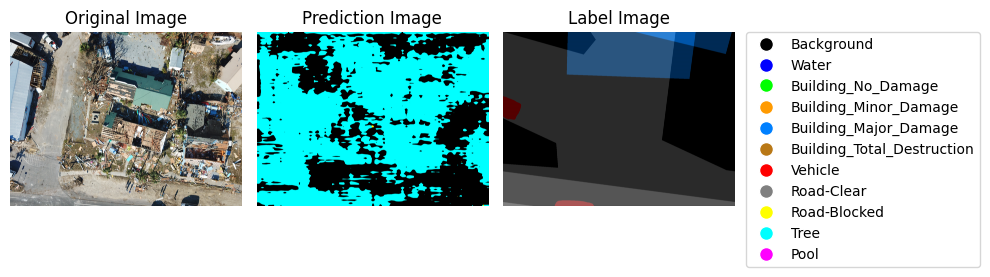

In [ ]:
train_set = RescueNetDataset(train_org_path, train_label_path, size=(800,500))
example_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
untrained_model = CustomDeepLabV3(num_classes=11, input_size=(800,500), output_size=(3000,4000))
SingleImage_evaluate(untrained_model, example_loader, 'train')

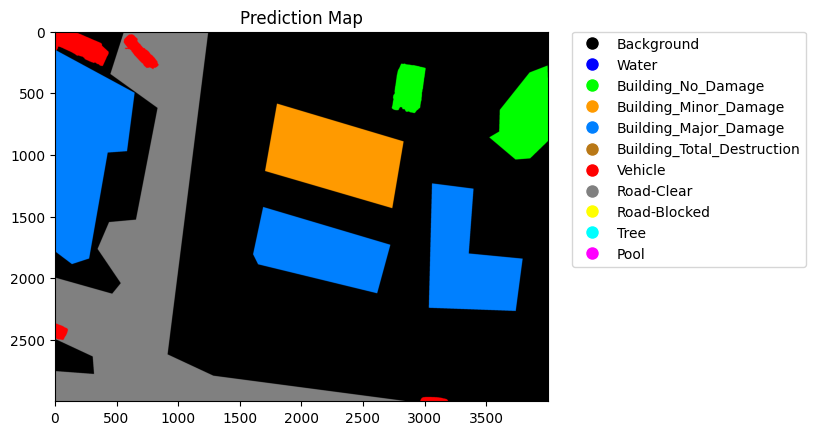

In [ ]:
img = cv.imread(train_label_path+'12850_lab.png')
display_classmap(img)

#### Training Loop

TRAINING JOURNAL
- trained model for 3 epochs
- freezing pretrained layers so I can train only the head.

In [ ]:
# freeze weights
for name, param in DL3_model.base_model.named_parameters():
  if 'classifier' not in name and 'aux_classifier' not in name:
    param.requires_grad = False

# # unfreeze weights
# for name, param in DL3_model.base_model.named_parameters():
#   if 'classifier' in name or 'aux_classifier' in name:
#     param.requires_grad = True


In [ ]:
# initalize objects for training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
DL3_model.to(device)
loss_fn_main = torch.nn.CrossEntropyLoss()
loss_fn_aux = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DL3_model.parameters(), lr=0.001)
aux_weight = 0.4

train_set = RescueNetDataset(train_org_path, train_label_path, size=(800,500))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=25, shuffle=True) #100 50 to much

In [ ]:
# Run training loop
num_epochs = 7
batch_loss = []
start_time = time.time()
for epoch in range(num_epochs):
    DL3_model.train()
    running_loss = 0.0
    for batch_idx, (file_idx, image, label) in enumerate(train_loader):

        image, label = image.to(device), label.to(device)
        label = label.squeeze(1).long()  # Remove the channel dimension (assuming it's 1)
        main_output, aux_output = DL3_model(image)

        main_loss = loss_fn_main(main_output, label)
        aux_loss = loss_fn_aux(aux_output, label)
        total_loss = main_loss + aux_weight * aux_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        batch_loss.append(total_loss.item())


        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {total_loss.item():.4f} ")
            print('runtime: ', time.time()-start_time)
            print('----------')


        del image, label, main_output, aux_output, main_loss, aux_loss, total_loss

    torch.save(DL3_model.state_dict(), model_path+"model2_epoch_"+str(epoch+1)+".pth")
    np.save(model_path+'model2_batch_loss.npy', np.array(batch_loss))
print('Finished Training')


Epoch [1/7], Batch [1/144], Loss: 3.6723 
runtime:  80.19642424583435
----------
Epoch [1/7], Batch [11/144], Loss: 1.2221 
runtime:  868.2110078334808
----------
Epoch [1/7], Batch [21/144], Loss: 1.2560 
runtime:  1661.2304022312164
----------
Epoch [1/7], Batch [31/144], Loss: 1.0742 
runtime:  2460.611516237259
----------
Epoch [1/7], Batch [41/144], Loss: 0.7846 
runtime:  3253.155502796173
----------
Epoch [1/7], Batch [51/144], Loss: 1.0326 
runtime:  4052.5200729370117
----------
Epoch [1/7], Batch [61/144], Loss: 0.7860 
runtime:  4918.371403455734
----------
Epoch [1/7], Batch [71/144], Loss: 0.7321 
runtime:  5716.427065849304
----------
Epoch [1/7], Batch [81/144], Loss: 0.9265 
runtime:  6517.325582265854
----------
Epoch [1/7], Batch [91/144], Loss: 0.9118 
runtime:  7299.186763763428
----------
Epoch [1/7], Batch [101/144], Loss: 0.8162 
runtime:  8115.1507477760315
----------
Epoch [1/7], Batch [111/144], Loss: 0.8218 
runtime:  8925.707570075989
----------
Epoch [1/7],

## Validation Pipeline

In [15]:
val_set = RescueNetDataset(val_org_path, val_label_path, size=(800,500))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=2, shuffle=True)

model_1 iou: 0.3854588270187378
eval time 16.004174947738647
15574.jpg


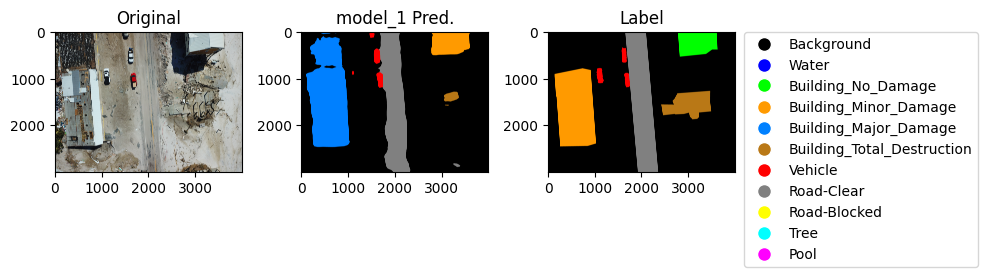

model_2 iou: 0.35041964054107666
eval time 16.405705213546753
15574.jpg


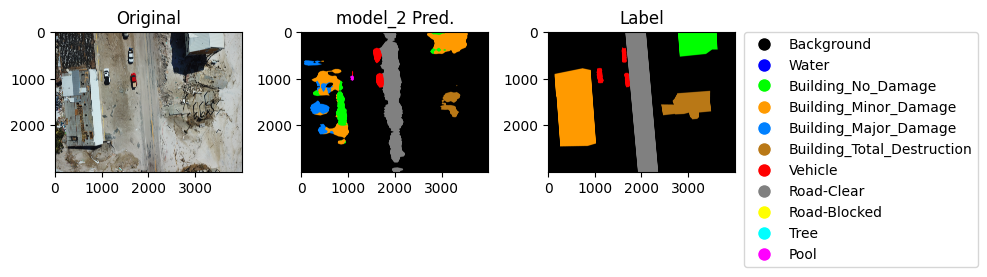

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[9, 9, 9,  ..., 9, 9, 9],
          [9, 9, 9,  ..., 9, 9, 9],
          [9, 9, 9,  ..., 9, 9, 9],
          ...,
          [0, 0, 0,  ..., 7, 7, 7],
          [0, 0, 0,  ..., 7, 7, 7],
          [0, 0, 0,  ..., 7, 7, 7]]], dtype=torch.uint8),
 ('15574.jpg', '15398.jpg'))

In [21]:
SingleImage_evaluate({'model_1':DL3_model_1 ,'model_2':DL3_model_2}, val_loader, 'val')

In [ ]:
# IoU Evaluation look
iou_model2_val = MulticlassJaccardIndex(num_classes=11).to(device = "cuda" if torch.cuda.is_available() else "cpu")
batch_val_iou = []
DL3_model_2.eval()
start = time.time()
for batch_idx, (file_idx, image, label)  in enumerate(val_loader):
  image, label = image.to(device), label.to(device)
  label = label.squeeze(1)  # Remove the channel dimension (assuming it's 1)
  main_output, _ = DL3_model_2(image)
  main_output = torch.argmax(main_output, dim=1)
  iou_model2_val.update(main_output, label)

  del image, label, main_output
  if batch_idx % 10 == 0:
    iou = iou_model2_val.compute()
    print(f"Batch [{batch_idx+1}/{len(val_loader)}], iou: {iou}")
    print('runtime: ', time.time()-start)
    batch_val_iou.append(iou)
    np.save(model2_path+'iou_model.npy', np.array(batch_val_iou))

print("Validation Done")
print(f"Validation IoU: {iou_model2_val.compute()}")

Batch [1/45], iou: 0.3823468089103699
runtime:  117.88795614242554
Batch [11/45], iou: 0.47670817375183105
runtime:  1020.448310136795
Batch [21/45], iou: 0.4857557415962219
runtime:  1917.3910009860992
Batch [31/45], iou: 0.47306206822395325
runtime:  2812.5000228881836
Batch [41/45], iou: 0.47711190581321716
runtime:  3707.5329575538635
Validation Done
Validation IoU: 0.4757460653781891


In [ ]:
# IoU Evaluation look
iou_model1_val = MulticlassJaccardIndex(num_classes=11).to(device = "cuda" if torch.cuda.is_available() else "cpu")
batch_val_1_iou = []
DL3_model_1.eval()
start = time.time()
for batch_idx, (file_idx, image, label)  in enumerate(val_loader):
  image, label = image.to(device), label.to(device)
  label = label.squeeze(1)  # Remove the channel dimension (assuming it's 1)
  main_output, _ = DL3_model_1(image)
  main_output = torch.argmax(main_output, dim=1)
  iou_model1_val.update(main_output, label)

  del image, label, main_output
  if batch_idx % 10 == 0:
    iou = iou_model1_val.compute()
    print(f"Batch [{batch_idx+1}/{len(val_loader)}], iou: {iou}")
    print('runtime: ', time.time()-start)
    batch_val_1_iou.append(iou)
    np.save(model1_path+'iou_model_1.npy', np.array(batch_val_1_iou))

print("Validation Done")
print(f"Validation IoU: {iou_model1_val.compute()}")

Batch [1/45], iou: 0.44402432441711426
runtime:  96.68611812591553
Batch [11/45], iou: 0.5141282081604004
runtime:  948.4512519836426
Batch [21/45], iou: 0.5013821721076965
runtime:  1801.5281472206116
Batch [31/45], iou: 0.500204861164093
runtime:  2645.15021276474
Batch [41/45], iou: 0.5071520209312439
runtime:  3496.1197855472565
Validation Done
Validation IoU: 0.505584180355072


In [ ]:
iou_model2_val

tensor(0.4850)

## Testing Pipeline

In [ ]:
# IoU Evaluation
test_set = RescueNetDataset(test_org_path, test_label_path, size=(800,500))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

start = time.time()

iou_metric_test = MulticlassJaccardIndex(num_classes=11).to(device = "cuda" if torch.cuda.is_available() else "cpu")
total_test_iou = []
for batch_idx, (file_idx, image, label)  in enumerate(test_loader):
  DL3_model.eval()
  image, label = image.to(device), label.to(device)
  label = label.squeeze(1)  # Remove the channel dimension (assuming it's 1)
  main_output, _ = DL3_model(image)
  main_output = torch.argmax(main_output, dim=1)
  iou_metric_test.update(main_output, label)

  del image, label, main_output

  if batch_idx % 10 == 0:
    iou = iou_metric_test.compute()
    print(f"Batch [{batch_idx+1}/{len(test_loader)}], iou: {iou}")
    print('runtime: ', time.time()-start)
    total_test_iou.append(iou)


  break

Batch [1/450], iou: 0.2936132550239563
runtime:  9.091396808624268


## Graphs

In [ ]:
model1_path+'batch_loss.npy'

'drive/MyDrive/comp-vision-project/data/RescueNet.zip_(Unzipped Files)/model_weights/model1_weights/batch_loss.npy'

In [ ]:
model1_batch_loss = np.load(model1_path+'/batch_loss.npy')
model2_batch_loss = np.load(model2_path+'/model2_batch_loss.npy')
#m1_loss_df = pd.read_excel(model1_path+'/run_1/model_1_batch_loss.xlsx')
model2_batch_loss = model2_batch_loss[-model1_batch_loss.shape[0]:]
model2_batch_loss.shape

(643,)

In [ ]:
model1_batch_loss.mean()

np.float64(0.5413505587477706)

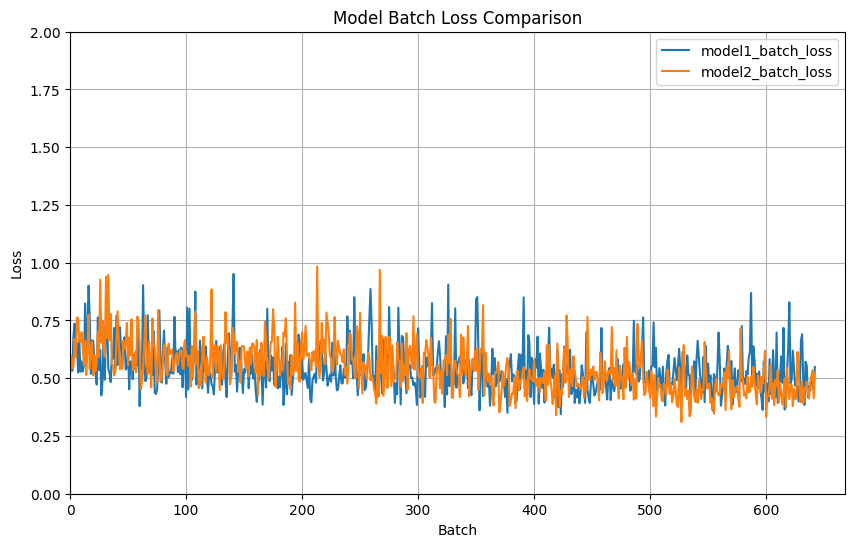

In [10]:
# prompt: plot model2_batch_loss and model1_batch_loss on a line graph using matplotlib. use all of model1_batch_loss but only use the same samples from model2 but from the end of the array

import matplotlib.pyplot as plt

# Assuming model1_batch_loss and model2_batch_loss are already loaded as numpy arrays
# Load the loss data (replace with your actual file paths)
model1_path = data_path + 'model_weights/model1_weights/'
model2_path = data_path + 'model_weights/model2_weights/'
model1_batch_loss = np.load(model1_path + '/batch_loss.npy')
model2_batch_loss = np.load(model2_path + '/model2_batch_loss.npy')

num_batches = len(model1_batch_loss)
# Truncate model2_batch_loss to match the length of model1_batch_loss
model2_batch_loss = model2_batch_loss[-num_batches:]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(model1_batch_loss, label='model1_batch_loss')
plt.plot(model2_batch_loss, label='model2_batch_loss')

# Add labels and title
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.xlim(0, num_batches+25)
plt.ylim(0, 2)
plt.title('Model Batch Loss Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Archive

In [ ]:
# # https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_deeplabv3_resnet101.ipynb
# dl3_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights= DeepLabV3_ResNet50_Weights.DEFAULT)
# dl3_model.classifier = DeepLabHead(2048, 11) # change prediction head to 10 classes
# dl3_model.aux_classifier = DeepLabHead(1024, 11) # change training head to 10 classes